# Feature Extraction using KS-test
Sep 10, 2020  
지난 histogram을 통해 확인한 변수별 분포를 바탕으로 진행한 feature extraction trial

In [1]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

pd.set_option('display.max_rows', 100)
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn')

In [3]:
pathList = glob.glob('../raw/*')
for idx, p in enumerate(pathList[:4]):
    name = p.split(' ')[-1].split('.')[0]
    print(f'Load {name}')
    if idx < 3:
        globals()[name] = pd.read_csv(p, engine='python')
    else:
        globals()[name] = pd.read_excel(p)

Load mrc_info
Load samp_train
Load samp_cst_feat
Load variable_dtype


## KS-검정(Kolmogorov-Smirnov test)
- H0: 분포 X1, X2 간의 차이가 없다
- 연속형 데이터에 사용 가능
- 필요한 표본 크기가 상대적으로 작음
- 모수 추정 정확도 낮음

In [89]:
from scipy.stats import ks_2samp


def KStest(var_num, data, plot=True, verbose=False):
    var = 'VAR' + str(var_num).zfill(3) if isinstance(var_num, int) else var_num
    showFranchiseDensity(var_num=var, data=data, franchise_group=[0, 1], plot=plot)
    stats = ks_2samp(data[data['MRC_ID_DI']==0][var], data[data['MRC_ID_DI']==1][var])
    if verbose:
        print(stats)
    return stats

def franchiseLabeling(franchise_num=1, dropID=True, verbose=True):
    '''각 가맹점 별로 학습 환경을 조성하기 위한 함수
    
    Arguments
    ---------
    franchise_num: 레이블링 기준이 될 가맹점 번호
    dropID: 고객ID를 제거할지 여부'''
    result = samp_cst_feat.merge(samp_train, how='left', on='cst_id_di')
    idx = result[result['MRC_ID_DI'] == franchise_num].index
    result['MRC_ID_DI'] = 0
    result.loc[idx, 'MRC_ID_DI'] = 1
    if verbose:
        print(f'기준 가맹점 Category: {franchise_num}')
        print(f'회원ID 컬럼 제거 여부: {dropID}')
    if dropID:
        return result.drop('cst_id_di', axis=1)
    return result

def showFranchiseDensity(var_num, bins=11, data=None, franchise_group=None, 
                         plot=True, figsize=(16,6)):
    '''가맹점별로 구간별 density 테이블과 히스토그램을 리턴하는 함수
    
    Arguments
    ---------
    var_num: integer or string, 변수 번호(VARXXX의 번호 또는 전체 문자열)
    bins: 나눌 구간 갯수
    data: 활용할 데이터
    franchise_group: list, 특정 가맹점만 관찰할 때
    plot: boolean, True시 히스토그램 플롯 리턴
    figsize: iterable whose length is 2, plot size 결정
    '''
    if data is None:
        data = train_raw.copy()
    if franchise_group is None:
        frequency_table = (train_raw['MRC_ID_DI']
                           .value_counts()
                           .to_frame('Freq')
                           .reset_index()
                           .rename({'index': 'MRC_ID_DI'}, axis=1))

        franchiseFreq = {row['MRC_ID_DI']:row['Freq'] 
                         for _, row in frequency_table.iterrows()}
        franchise_group = [i for i in range(11)]
    else:
        frequency_table = (data['MRC_ID_DI']
                           .value_counts()
                           .to_frame('Freq')
                           .reset_index()
                           .rename({'index': 'MRC_ID_DI'}, axis=1))

        franchiseFreq = {row['MRC_ID_DI']:row['Freq'] 
                         for _, row in frequency_table.iterrows()}
    if isinstance(var_num, int):
        var = 'VAR' + str(var_num).zfill(3)
    else:
        var = var_num
        
    partial = data[[var, 'MRC_ID_DI']]
    hist, quantiles =  np.histogram(partial.iloc[:, 0], bins=bins)

    result_raw = {}
    for group in franchise_group:
        density_list = []
        for i in range(bins):
            partialpartial = partial[partial['MRC_ID_DI'] == group]
            density = (len(partialpartial[
                (partialpartial[var] >= quantiles[i]) & 
                (partialpartial[var] <= quantiles[i + 1])
            ]) / franchiseFreq[group])
            density_list.append(density)
        result_raw[group] = density_list

    result = (pd.melt(
        (pd.DataFrame(result_raw)
         .reset_index()
         .rename({'index':'interval_Id'}, axis=1))
        , id_vars='interval_Id')
                  .rename({'variable':'MRC_ID_DI', 'value':'density'}, axis=1))
    
    if plot:
        plt.figure(figsize=figsize)
        sns.barplot(x='interval_Id', y='density', hue='MRC_ID_DI', data=result,
                   palette=sns.color_palette("Paired"))
        plt.suptitle('Density for each Franchise')
        plt.title(var)
        plt.show()
        
    return result

In [122]:
for f in range(1, 11):
    data = franchiseLabeling(franchise_num=f)
    (pd.Series({col:p 
               for col in data.columns[:-1] 
               for p in KStest(var_num=col, data=data, plot=False)})
     .to_frame('p_value')
     .reset_index()
     .rename({'index': 'var'}, axis=1)
     .to_csv(f'./ks_test_reports/pvalues_franchise{str(f).zfill(2)}.csv', index=False))
    print(f'franchise {f} report saved.')

기준 가맹점 Category: 1
회원ID 컬럼 제거 여부: True
franchise 1 report saved.
기준 가맹점 Category: 2
회원ID 컬럼 제거 여부: True
franchise 2 report saved.
기준 가맹점 Category: 3
회원ID 컬럼 제거 여부: True
franchise 3 report saved.
기준 가맹점 Category: 4
회원ID 컬럼 제거 여부: True
franchise 4 report saved.
기준 가맹점 Category: 5
회원ID 컬럼 제거 여부: True
franchise 5 report saved.
기준 가맹점 Category: 6
회원ID 컬럼 제거 여부: True
franchise 6 report saved.
기준 가맹점 Category: 7
회원ID 컬럼 제거 여부: True
franchise 7 report saved.
기준 가맹점 Category: 8
회원ID 컬럼 제거 여부: True
franchise 8 report saved.
기준 가맹점 Category: 9
회원ID 컬럼 제거 여부: True
franchise 9 report saved.
기준 가맹점 Category: 10
회원ID 컬럼 제거 여부: True
franchise 10 report saved.


In [179]:
colors = {1: '#E67C7C', 2: '#F19E6B', 3: '#E9D120', 4: '#A8D052', 5: '#9EEA53',
         6: '#67F24B', 7: '#4FE6C5', 8: '#3EADE2', 9: '#6F77EE', 10: '#CF6BF0'}
def showPvaluePlot(franchise_group=None, figsize=(45, 6), save=False):
    if franchise_group is None:
        franchise_group = [i for i in range(1, 11)]
    ks_paths = glob.glob('./ks_test_reports/*.csv')
    f = plt.figure(figsize=figsize)
    
    for group in franchise_group:
        df = pd.read_csv(ks_paths[group-1])
        plt.plot(df['var'], df['p_value'], label=f'franchise {group}', color=colors[group])
    
    plt.ylabel('P-values')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title(f'P-values for each VAR within franchise {franchise_group}')
    plt.show()
    
    if save:
        f.savefig(f'./ks_test_reports/plots/pvalue_plot_franchise{franchise_group}')

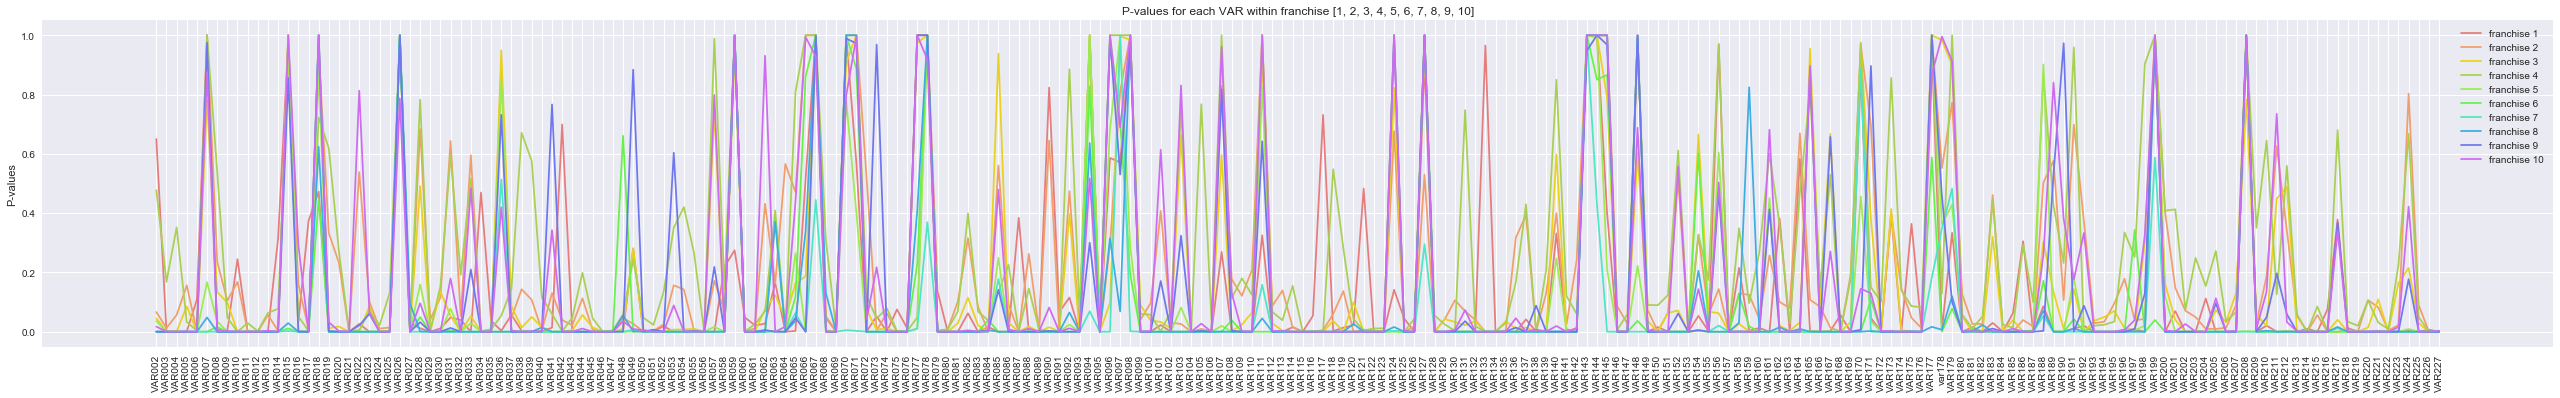

In [170]:
showPvaluePlot(save=True)

In [175]:
# for i in range(1, 11):
#     showPvaluePlot(franchise_group=[i], save=True)

In [176]:
# showPvaluePlot(franchise_group=[6,7,8], save=True)

In [177]:
# showPvaluePlot(franchise_group=[1,2,3], save=True)

In [178]:
# showPvaluePlot(franchise_group=[3,6,9], save=True)

가맹점마다 변수별 KS-test의 pvalue값이 다르게 측정됨  
변수선택을 가맹점에 따라 달리할 필요가 있음

## Feature Selection
KS-검정으로부터 얻게된 p-value를 활용하여 변수를 선택한다  
적당한 threshold를 설정하는 것이 관건  
근데, 그냥 러프한 모델로 학습시켜가면서 성능이 가장 잘 나오는 threshold를 아는게 좋을듯 기록하는게 효율적일듯

우선, 아래 그림과 같이 가맹점 별 p-value의 분포가 확연히 다르다

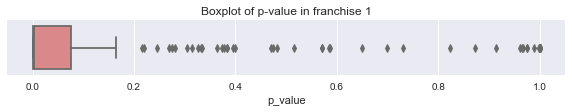

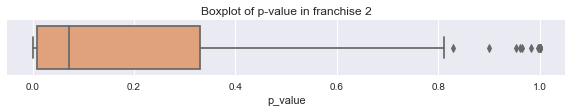

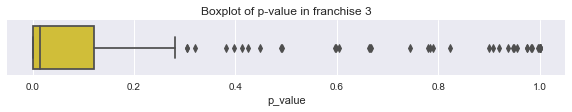

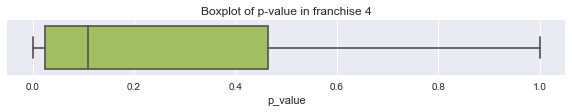

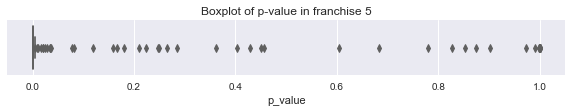

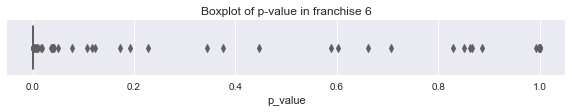

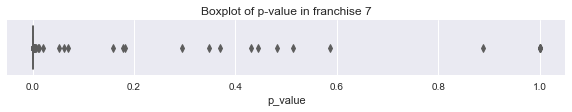

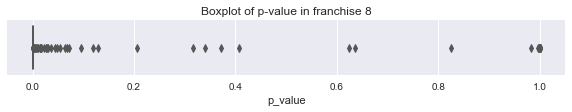

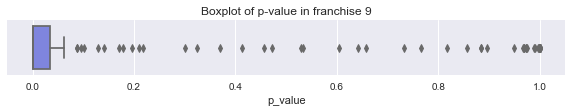

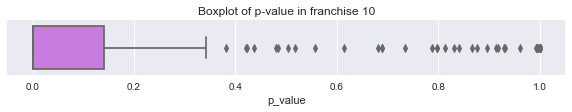

In [222]:
ks_paths = glob.glob('./ks_test_reports/*.csv')
for franchise_num in range(1, 11):
    data = pd.read_csv(ks_paths[franchise_num - 1])
    
    plt.figure(figsize=(10,1))
    sns.boxplot(data['p_value'], color=colors[franchise_num])
    plt.title(f'Boxplot of p-value in franchise {franchise_num}')
    plt.show()

가맹점 5, 6, 7, 8의 경우 p-value값이 전반적으로 아주 작은 값으로 몰려있음  
=> 대부분의 변수가 중요하게 작용할 것으로 추론해볼 수 있음

### Metric Funciton
* LIFT(LIFT@20): 예측한 데이터 기준 상위 20% 데이터 중 1의 비율 / 전체 데이터에서 1의 비율
* AUROC
* Final Score: 0.7\*(LIFT/5) + 0.3\*AUROC

In [343]:
isinstance(y.values, pd.Series)

False

In [429]:
from sklearn.metrics import roc_auc_score


def final_score(y_true, y_score, verbose=True):
    '''Final Score를 가진 딕셔너리 리턴'''
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    lift = lift20(y_true=y_true, y_score=y_score, verbose=False)
    auroc = roc_auc_score(y_true=y_true, y_score=y_score)
    final_score = 0.7*(lift/5) + 0.3*(auroc)
    
    if verbose:
        print('LIFT:\t\t', lift)
        print('AUC:\t\t', auroc)
        print('Final Score:\t', final_score)
        
    return {'final_score': final_score, 'lift': lift, 'auroc': auroc}


def lift20(y_true, y_score, verbose=True):
    '''LIFT20 측정
    
    Arguments
    ---------
    y_true: pandas.core.series.Series, numpy.ndarray, 참값
    y_score: pandas.core.series.Series, numpy.ndarray, 예측 결과
    verbose: boolean, 상세 정보 출력 여부'''
    total_ones_rate = len(y_true[y_true==1]) / len(y_true) # 전체 데이터 내 1의 비율
    
    q20 = int(np.ceil(len(y_score) * 0.2))
    descending_order_idx = np.argsort(-y_score).tolist() # 예측한 확률을 기준으로 내림차순 정리
    q20_data = y_true[descending_order_idx][:q20]
    q20_ones_rate = len(q20_data[q20_data == 1]) / len(q20_data)
    
    if verbose:
        print('전체 데이터 내 타깃 1인 데이터 수:\t\t', len(y_true[y_true==1]))
        print('전체 데이터 내 타깃 참값 1인 데이터 비율:\t\t\t', total_ones_rate)
        print('예측 상위20% 데이터 갯수:\t\t\t', len(q20_data))
        print('예측 상위20% 데이터 내 타깃 참값이 1인 데이터 수:\t', len(q20_data[q20_data == 1]))
        print('예측 상위20% 데이터 내 타깃 참값이 1인 데이터 비율:\t\t', q20_ones_rate)
    
    return q20_ones_rate / total_ones_rate


In [432]:
def franchiseLabeling(franchise_num=1, dropID=True, verbose=True):
    '''각 가맹점 별로 학습 환경을 조성하기 위한 함수. 기준 가맹점을 방문한 사람의 타깃 레이블은 1, 그렇지 않으면 0 처리한다.
    
    Arguments
    ---------
    franchise_num: int, 레이블링 기준이 될 가맹점 번호
    dropID: bool, 고객ID를 제거할지 여부'''
    result = samp_cst_feat.merge(samp_train, how='left', on='cst_id_di')
    idx = result[result['MRC_ID_DI'] == franchise_num].index
    result['MRC_ID_DI'] = 0
    result.loc[idx, 'MRC_ID_DI'] = 1
    if verbose:
        print(f'기준 가맹점 Category: {franchise_num}')
        print(f'회원ID 컬럼 제거 여부: {dropID}')
    if dropID:
        return result.drop('cst_id_di', axis=1)
    return result

In [456]:
franchise_num = 1


In [459]:
def autoFeatureSelection(franchise_num=1, k=4, estimator='rf',
                         random_state=42, verbose=False,
                         save=True, path='./ks_test_reports/feature_selection/'):
    '''pvalue값을 threshold로 변경시켜가며 feature selection을 한 뒤 모델로 성능을 측정함
    
    Arguments
    ---------
    franchise_num: integer, 가맹점 번호
    k: integer >= 2, CV할 때 사용되는 k
    random_state: int, 시드값
    save: bool, 저장 여부
    path: str, 저장 경로
    '''
    quantiles = [0.5 + i*0.05 for i in range(9)]
    data = franchiseLabeling(franchise_num=franchise_num, dropID=True, verbose=False)
    meta = pd.read_csv(f'./ks_test_reports/pvalues_franchise{str(franchise_num).zfill(2)}.csv')

    for q in quantiles:
        threshold = np.quantile(meta['p_value'], q)
        selected_features = list(meta[meta['p_value'] <= threshold]['var'].tolist())
        X, y = data.loc[:, selected_features], data['MRC_ID_DI']
        
        if estimator=='rf':
            model = RandomForestClassifier(random_state=random_state)
        cv = KFold(n_splits=k, random_state=random_state, shuffle=True)

        lifts, aurocs, finals = [], [], []
        for train_idx, valid_idx in cv.split(X):
            X_train, X_valid = X.iloc[train_idx, :], X.iloc[valid_idx, :]
            y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
            model.fit(X_train, y_train)

            pred = model.predict_proba(X_valid)[:, 1]
            score = final_score(y_true=y_valid, 
                                y_score=pred, 
                                verbose=verbose)
            lifts.append(score['lift'])
            aurocs.append(score['auroc'])
            finals.append(score['final_score'])

        result = dict(
            franchise_num=franchise_num,
            threshold=threshold,
            model=estimator,
            k=k,
            random_state=random_state,
            mean_final_score=np.mean(finals),
            mean_lift=np.mean(lifts),
            mean_auroc=np.mean(aurocs),
            n_features = len(selected_features),
            features=selected_features,
        )

        if save:
            file_name = f'franchise({str(franchise_num).zfill(2)})_threshold({str(threshold)[:8]}).json'
            with open(os.path.join(path, file_name), 'w') as file:
                json.dump(result, file)
            print(f'{os.path.join(path, file_name)} saved')

In [461]:
franchise_group = [i for i in range(1,11)]
for f in franchise_group:
    print('가맹점 번호:', f)
    autoFeatureSelection(franchise_num=f, k=4, random_state=42)

가맹점 번호: 1
./ks_test_reports/feature_selection/franchise(01)_threshold(0.002797).json saved
./ks_test_reports/feature_selection/franchise(01)_threshold(0.007758).json saved
./ks_test_reports/feature_selection/franchise(01)_threshold(0.013605).json saved
./ks_test_reports/feature_selection/franchise(01)_threshold(0.026629).json saved
./ks_test_reports/feature_selection/franchise(01)_threshold(0.048260).json saved
./ks_test_reports/feature_selection/franchise(01)_threshold(0.075213).json saved
./ks_test_reports/feature_selection/franchise(01)_threshold(0.269032).json saved
./ks_test_reports/feature_selection/franchise(01)_threshold(0.382792).json saved
./ks_test_reports/feature_selection/franchise(01)_threshold(0.618012).json saved
가맹점 번호: 2
./ks_test_reports/feature_selection/franchise(02)_threshold(0.072077).json saved
./ks_test_reports/feature_selection/franchise(02)_threshold(0.096321).json saved
./ks_test_reports/feature_selection/franchise(02)_threshold(0.115229).json saved
./ks_tes

결과 불러오기

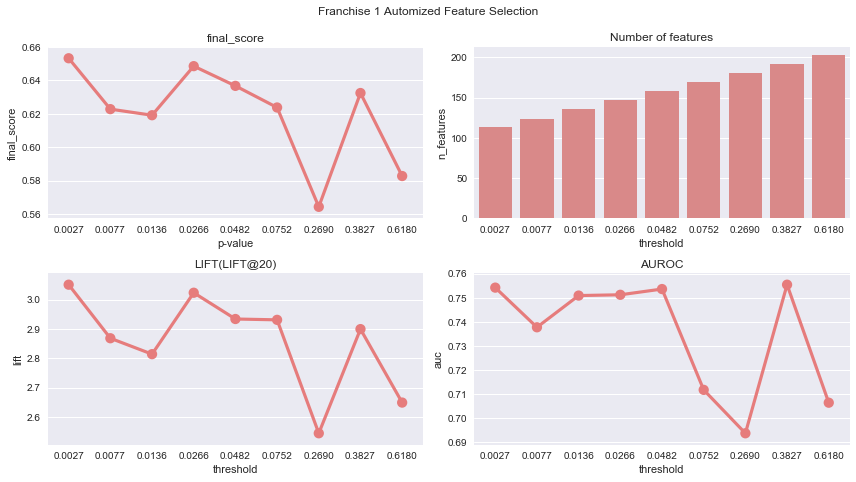

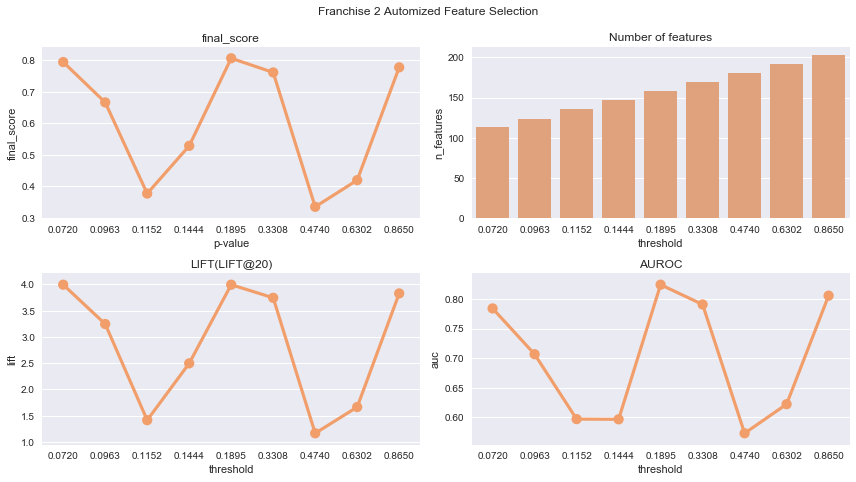

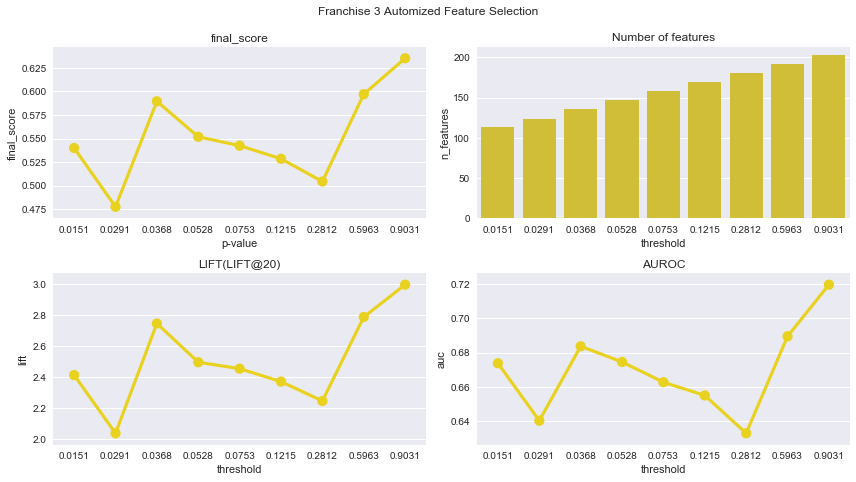

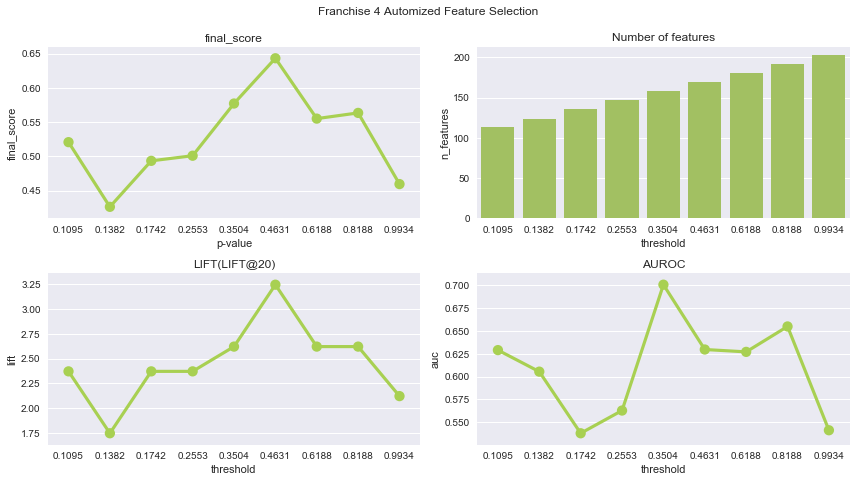

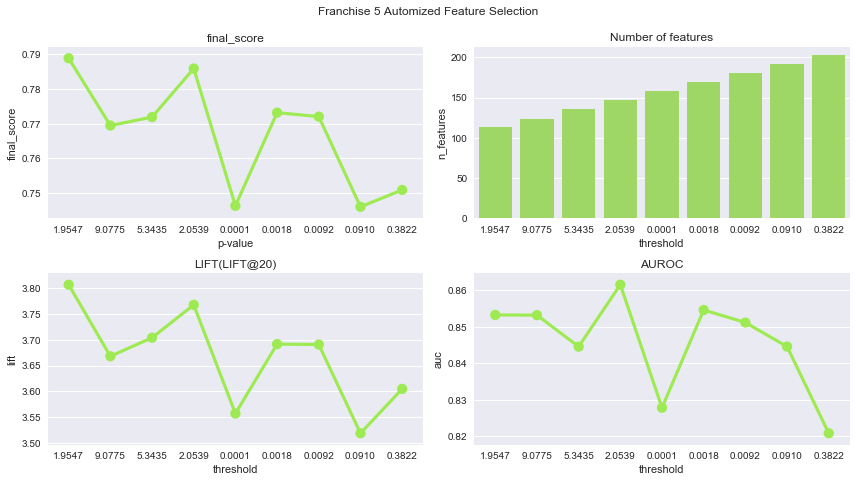

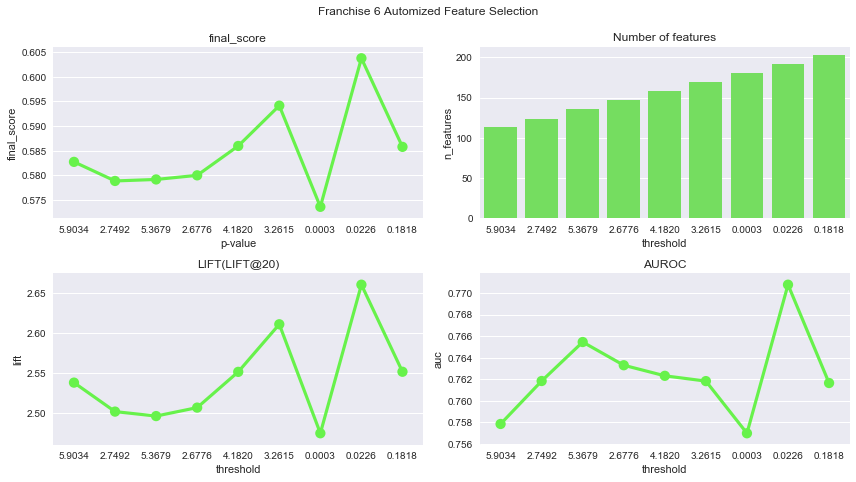

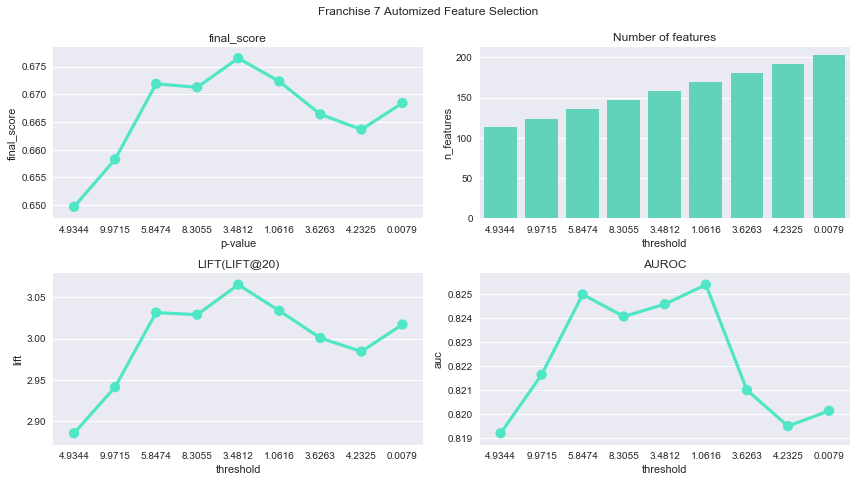

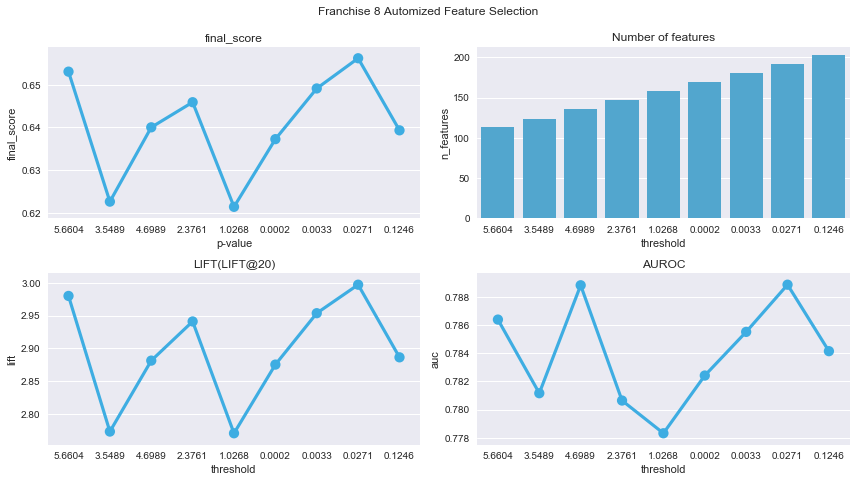

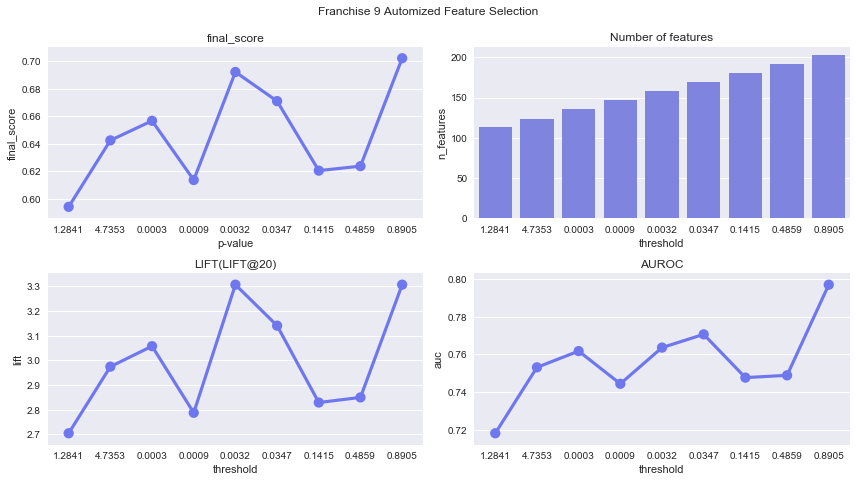

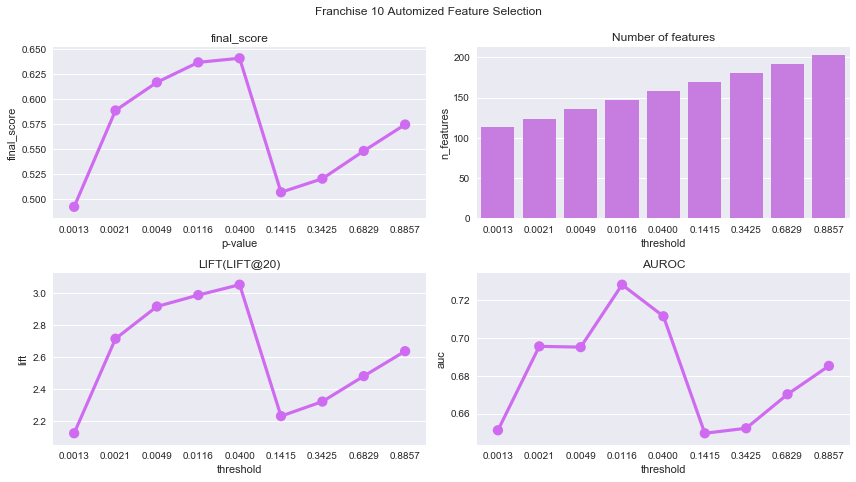

In [544]:
for i in range(1, 11):
    franchise_num = i
    path = './ks_test_reports/feature_selection/' # 결과 파일 경로
    reports = glob.glob(path + f'franchise({str(franchise_num).zfill(2)})*.json') # 결과 파일 이름

    output = dict(franchiseID=[], threshold=[], n_features=[], final_score=[], lift=[], auc=[])
    for r in reports:
        with open(r) as file: # 불러오기
            result = json.load(file)
        output['franchiseID'].append(result['franchise_num'])
        output['threshold'].append(result['threshold'])
        output['n_features'].append(result['n_features'])
        output['final_score'].append(result['mean_final_score'])
        output['lift'].append(result['mean_lift'])
        output['auc'].append(result['mean_auroc'])

    temp = pd.DataFrame(output).sort_values(by='threshold')
    temp.head()
    
    fig, ax = plt.subplots(2,2, figsize=(12,7))
    sns.pointplot(x = 'threshold', y='final_score', data=temp, color=colors[franchise_num], ax=ax[0,0])
    sns.barplot(x = 'threshold', y='n_features', data=temp, color=colors[franchise_num], ax=ax[0,1])
    sns.pointplot(x = 'threshold', y='lift', data=temp, color=colors[franchise_num], ax=ax[1,0])
    sns.pointplot(x = 'threshold', y='auc', data=temp, color=colors[franchise_num], ax=ax[1,1])
    
#     sns.pointplot(x = 'threshold', y='final_score', data=temp, color=colors[franchise_num])
    ax[0,0].set_xticklabels([str(t)[:6] for t in temp['threshold']])
    ax[0,0].set_title('final_score')
    ax[0,0].set_xlabel('p-value')
    
    ax[0,1].set_xticklabels([str(t)[:6] for t in temp['threshold']])
    ax[0,1].set_title('Number of features')
    
    ax[1,0].set_xticklabels([str(t)[:6] for t in temp['threshold']])
    ax[1,0].set_title('LIFT(LIFT@20)')
    
    ax[1,1].set_xticklabels([str(t)[:6] for t in temp['threshold']])
    ax[1,1].set_title('AUROC')
    
    plt.suptitle(f'Franchise {franchise_num} Automized Feature Selection')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    fig.savefig(f'./ks_test_reports/plots/Franchise {str(franchise_num).zfill(2)} Automized Feature Selection.png', dpi=300)